# Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Loading Dataset

In [2]:
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')

In [3]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
activities_map = {i:activities[i-1] for i in range(1, 7)}

In [4]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
    

In [5]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}") 
print(f'Shape of y_train = {y_train.shape}')

x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Shape of X_test = {x_test.shape}")
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (126, 500, 3)
Shape of y_train = (126,)
Shape of X_test = (54, 500, 3)
Shape of y_test = (54,)


### Task 1 Question 1

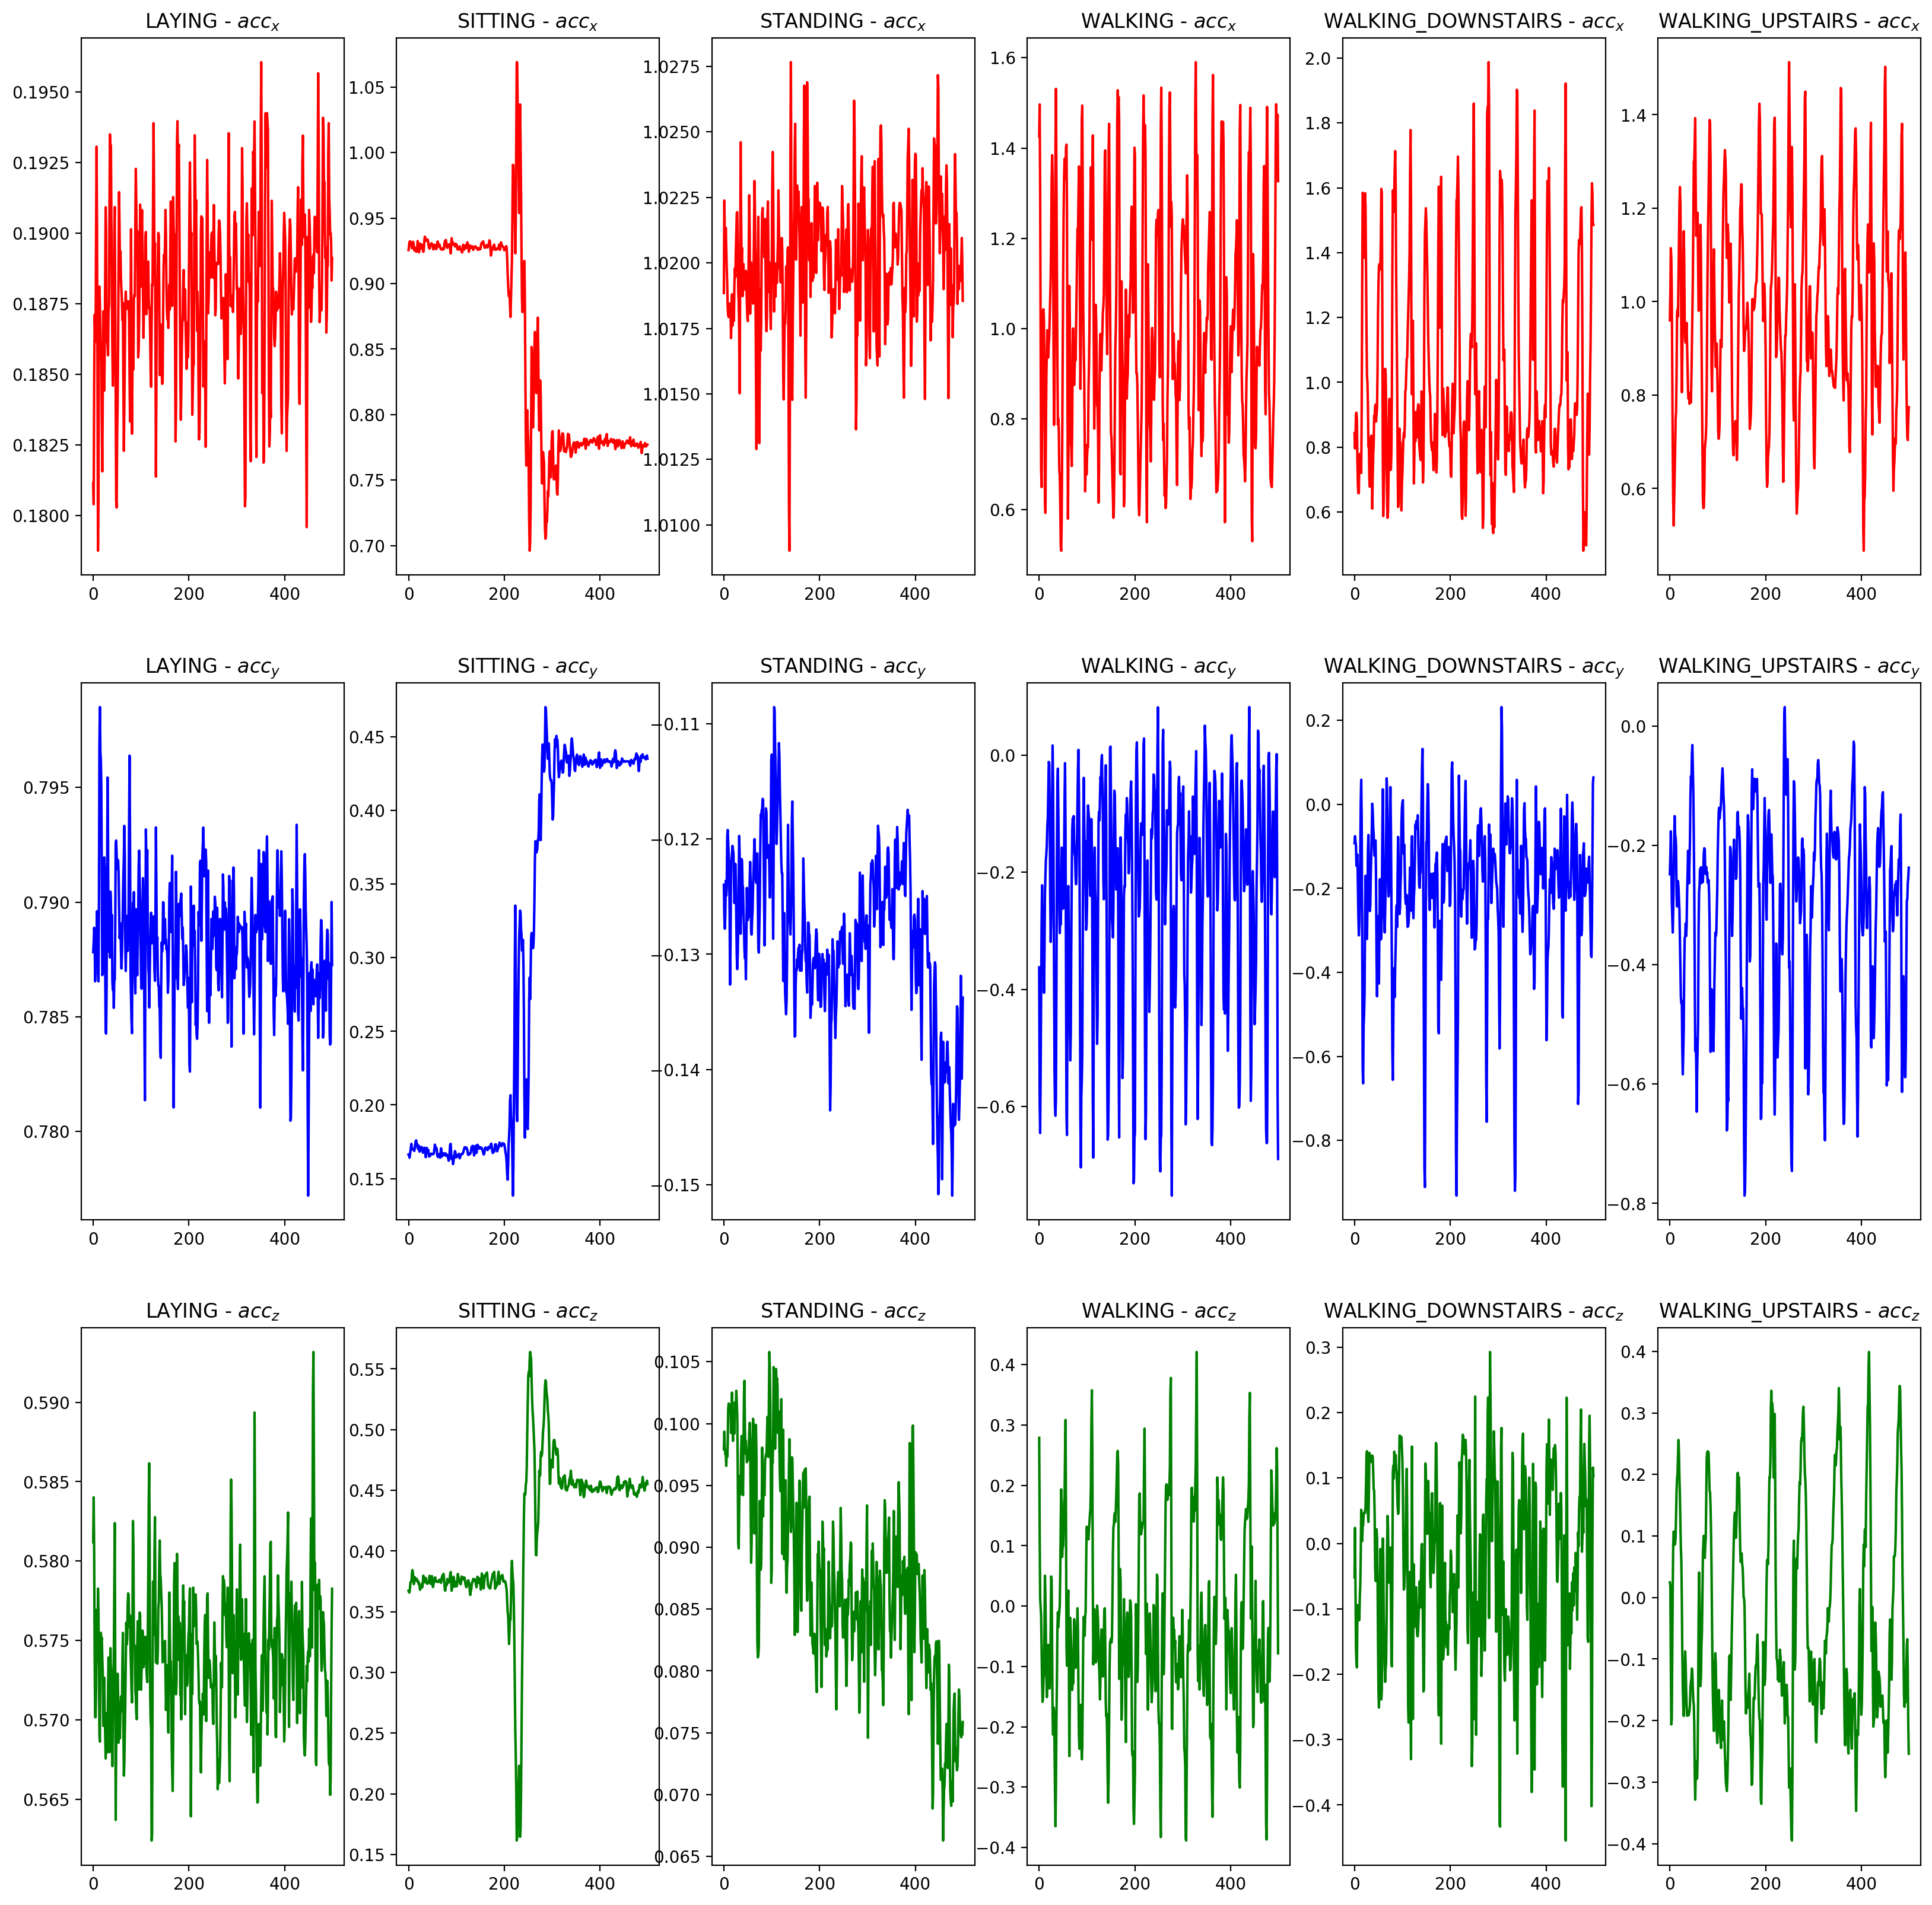

In [6]:
plt.figure(figsize=(20,20))
for i in range(6):
    activity = activities[i]
    data = x_train[i*21]
    acc_x = data[:,0]
    acc_y = data[:,1]
    acc_z = data[:,2]
    x = np.arange(0,500,1)
    plt.subplot(3,6,i+1)
    plt.plot(x,acc_x,c='r')
    plt.title(f"{activity} - $acc_x$")
    plt.subplot(3,6,i+7)
    plt.plot(x,acc_y,c='b')
    plt.title(f"{activity} - $acc_y$")
    plt.subplot(3,6,i+13)
    plt.plot(x,acc_z,c='g')
    plt.title(f"{activity} - $acc_z$")
plt.show()

The differences/similarities between the various activities are:
1. The variation in the accelerometer values of static acitivities like laying, sitting, and standing is much less than dynamic activities like walking, walking_upstairs and walking_downstairs.
2. The accelerometer readings are much different in the static activities (for example, acc x for laying is in the range (0.18,0.19), for sitting (0.7,1.05) and for standing (1.01,1.02) whereas its almost same for dynamic activities (0.6,1.5))

Yes, the model could classify the distinction between static and dynamic activities very clearly. Yet, it may face some difficulty in classifying among the different static and dynamic activities.

### Task 1, Question 2

In [26]:
total_acceleration = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2
total_acceleration_x_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
for i in range(len(activities)):
    activity=activities[i]
    var_ = total_acceleration[i*21:(i+1)*21].var()
    mean_ = total_acceleration[i*21:(i+1)*21].mean()
    print(f"Mean total acceleration for activity {activity} = {mean_}")
    print(f"Variance in  total acceleration for activity {activity} = {var_}")

Mean total acceleration for activity LAYING = 1.0103142450756741
Variance in  total acceleration for activity LAYING = 0.00046204993741151107
Mean total acceleration for activity SITTING = 1.029346570214143
Variance in  total acceleration for activity SITTING = 0.0005658598040530853
Mean total acceleration for activity STANDING = 1.0650814326336357
Variance in  total acceleration for activity STANDING = 0.00027748397579156124
Mean total acceleration for activity WALKING = 1.1545508057464684
Variance in  total acceleration for activity WALKING = 0.25233633148708084
Mean total acceleration for activity WALKING_DOWNSTAIRS = 1.227920255515466
Variance in  total acceleration for activity WALKING_DOWNSTAIRS = 0.8607093928038053
Mean total acceleration for activity WALKING_UPSTAIRS = 1.1661549538347427
Variance in  total acceleration for activity WALKING_UPSTAIRS = 0.36599943016717296


Yes, the model could easily classify between the static and dynamic activities, as the values of total acceleration are higher for dynamic activities than static. Moreover, there is a lot of variance in the values of total acceleration in dynamic activities than static.

In [8]:
total_acceleration.shape

(126, 500)

In [9]:
total_acceleration_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
print(total_acceleration_test.shape)

(54, 500)


# Question 2
There are many evident differences between the accelerometer data of static and dynamic actitvites. Therefore, we can  classify the activities by setting some threshold values for classifying based on the variance of the data. 

### Task 1, Question 3

#### PCA on Raw Data

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(total_acceleration)
pca_data = pca.transform(total_acceleration)
pca_data.shape


(126, 2)

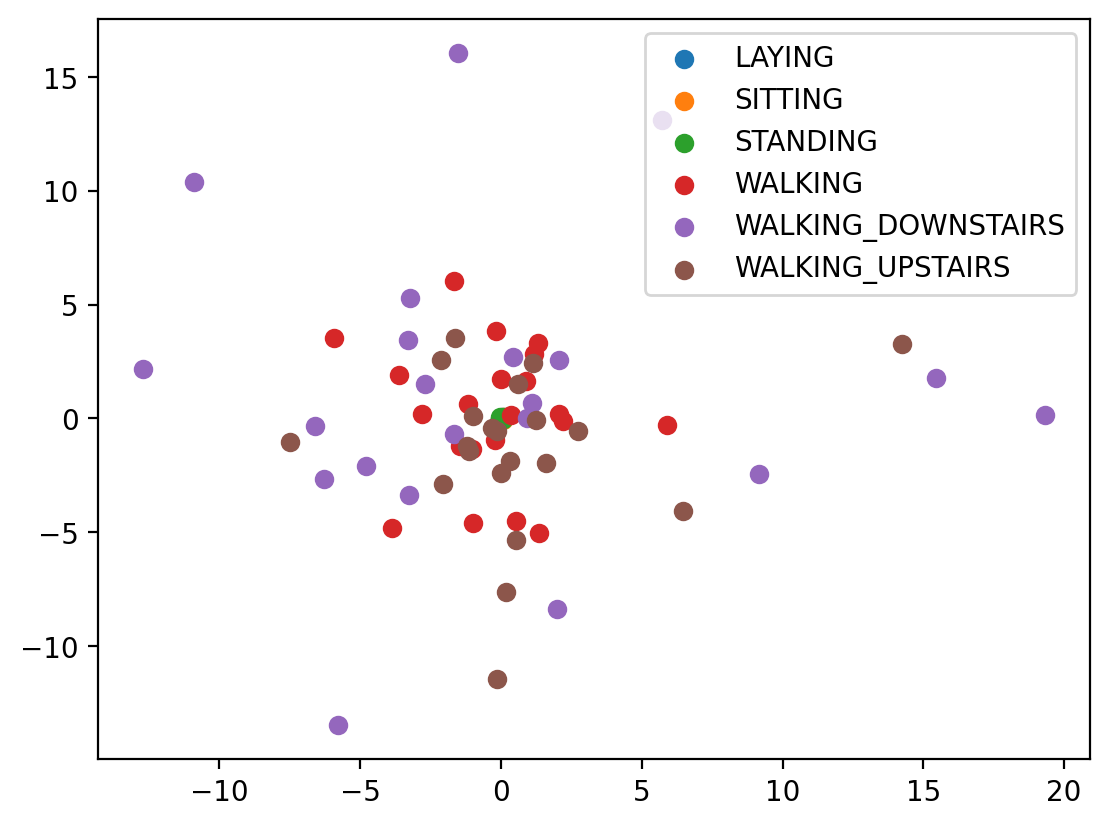

In [11]:

for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(pca_data[i*21:(i+1)*21,0],pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

#### Featurization using TSFEL

In [12]:
import tsfel
from tsfel.feature_extraction.features import calc_mean, calc_var, pk_pk_distance, mean_abs_deviation, auc, autocorr

In [13]:
def extract_features(data):
    tsfel_features=[]
    for i in range(len(data)):
        mean = calc_mean(data[i])
        var = calc_var(data[i])
        dist = pk_pk_distance(data[i])
        mad = mean_abs_deviation(data[i])
        corr = autocorr(data[i])
        auc_ = auc(data[i],50)
        tsfel_features.append([mean,var,dist,mad,corr,auc_])
    return tsfel_features


In [14]:
tsfel_features_train=np.array(extract_features(total_acceleration))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

In [15]:
print(tsfel_features_train.shape)
print(tsfel_features_test.shape)

(126, 6)
(54, 6)


In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(tsfel_features_train)
tsfel_pca_data = pca.transform(tsfel_features_train)
tsfel_pca_data.shape

(126, 2)

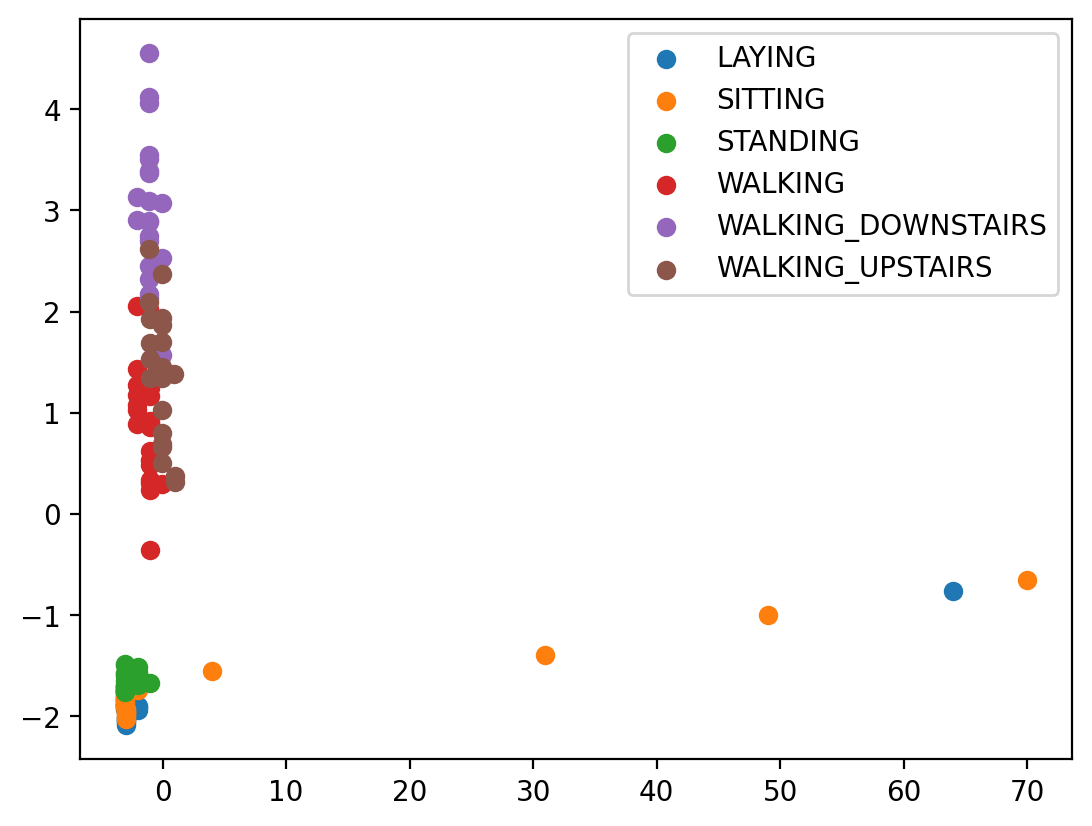

In [17]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(tsfel_pca_data[i*21:(i+1)*21,0],tsfel_pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

#### PCA on features provided in dataset

In [35]:
X_train_features = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
X_train_features.shape

(7352, 561)

In [36]:
y_train_features = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
y_train_features.shape

(7352,)

In [37]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_features)
X_train_pca_data = pca.transform(X_train_features)
X_train_pca_data.shape

(7352, 2)

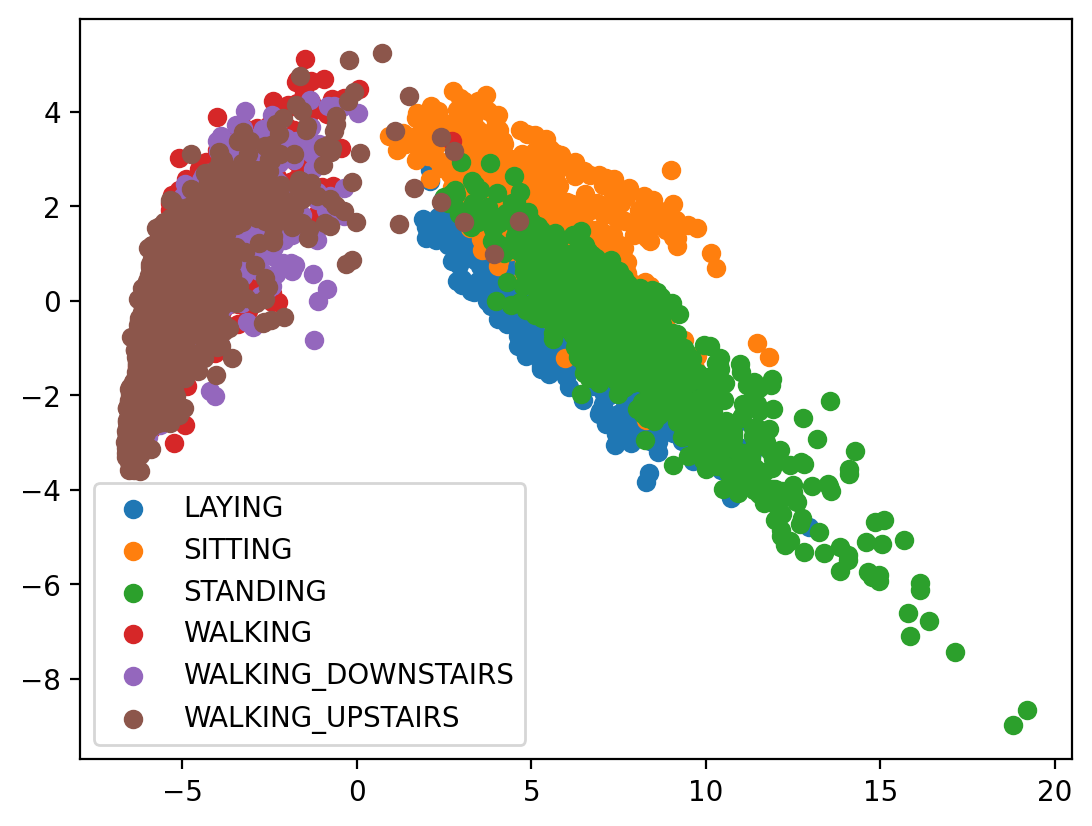

In [38]:
for i in range(1,7):
    plt.scatter(X_train_pca_data[y_train_features==i,0],X_train_pca_data[y_train_features==i,1],label=activities_map[i])
    plt.legend()
    

1. The PCA on the total_acceleration is very scattered and the different activities have very high overlapping region in that graph. 
2. Whereas, the PCA on TSFEL featurized data and on features provided in the data have better plots as different activities can be clearly distinguished in different clusters with less overlap.
3. Either of the TSFEL or dataset provided by the features is good for visualising the data.

### Task 2, Question 1

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

Accuracy = 0.5185185185185185
Precision = 0.5051948051948052
Recall = 0.5185185185185185
F1 Score = 0.4990890688259109


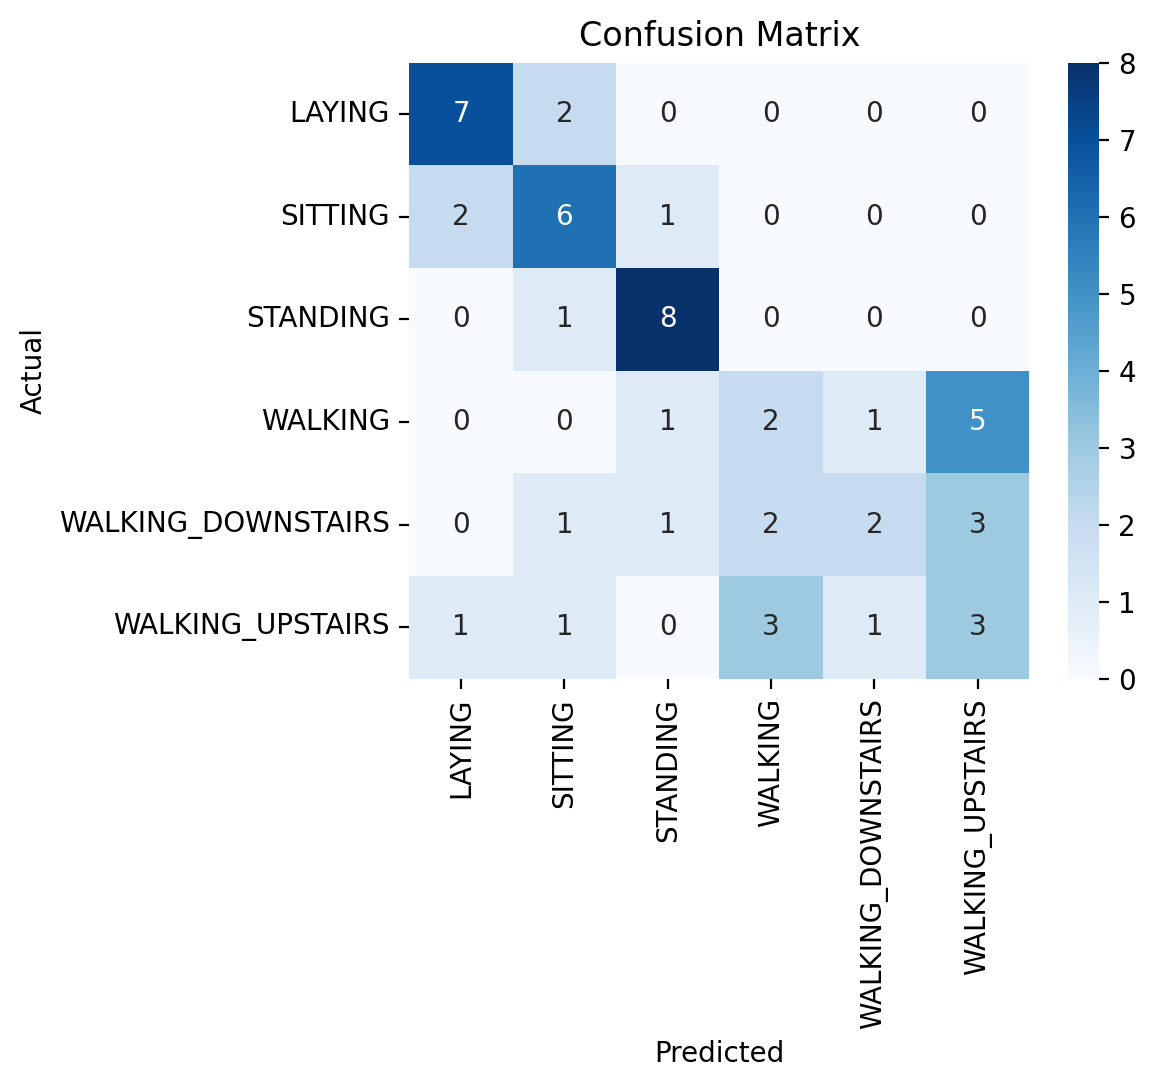

In [39]:
raw_data_tree = DecisionTreeClassifier()
raw_data_tree.fit(total_acceleration,y_train)
y_pred = raw_data_tree.predict(total_acceleration_test)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
print(f"Precision = {precision_score(y_test,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,y_pred,average='weighted')}")
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy = 0.8148148148148148
Precision = 0.8169191919191918
Recall = 0.8148148148148148
F1 Score = 0.8133986928104576


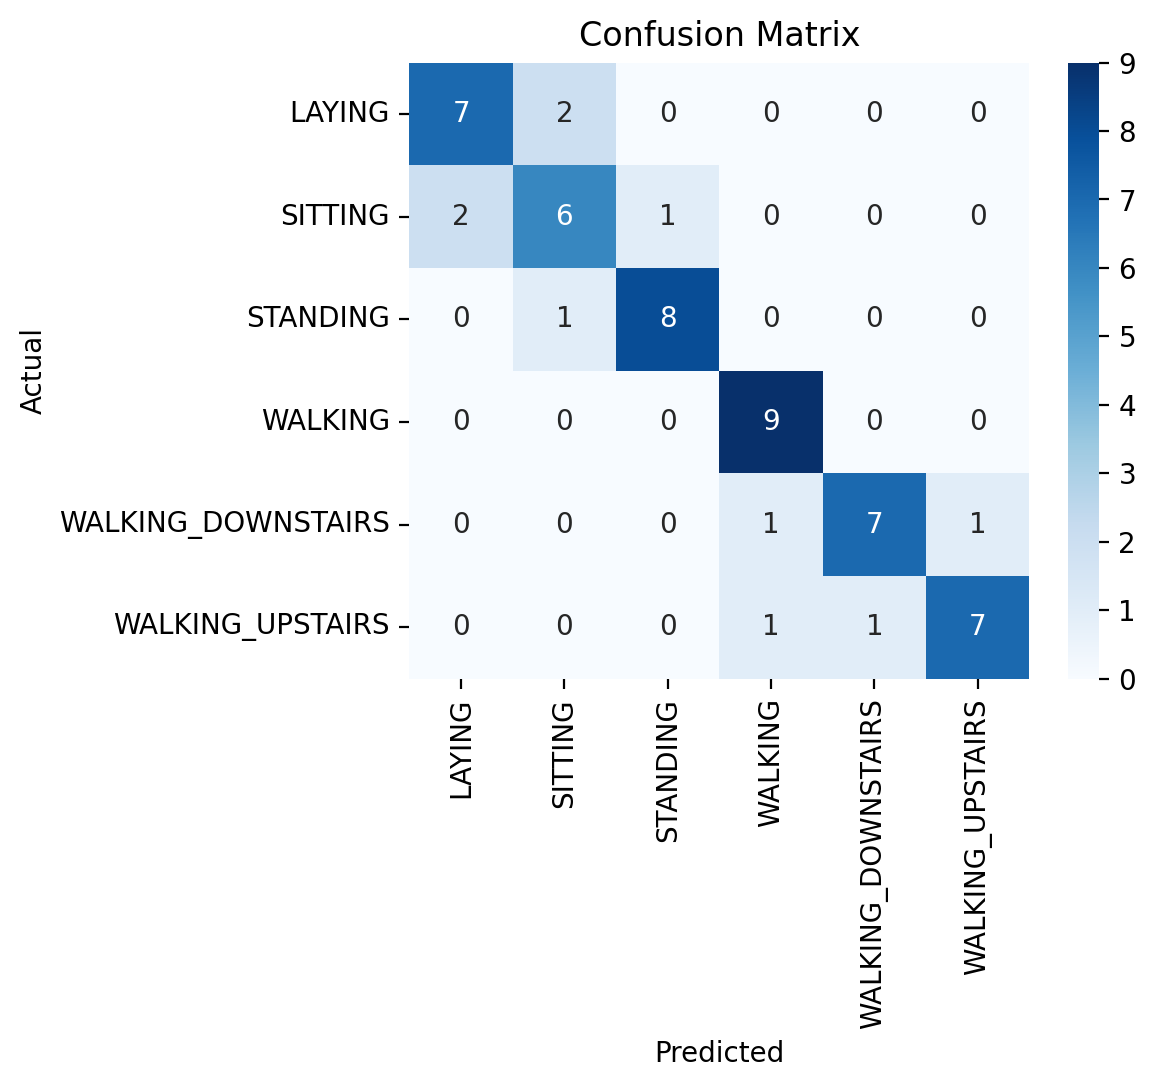

In [40]:
tsfel_tree = DecisionTreeClassifier()
tsfel_tree.fit(tsfel_features_train,y_train)
y_pred = tsfel_tree.predict(tsfel_features_test)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
print(f"Precision = {precision_score(y_test,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,y_pred,average='weighted')}")
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
X_test_features = np.loadtxt('UCI HAR Dataset/test/X_test.txt')
X_test_features.shape

(2947, 561)

In [42]:
y_test_features = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_test_features.shape

(2947,)

Accuracy = 0.8625721072276892
Precision = 0.8632697389609315
Recall = 0.8625721072276892
F1 Score = 0.8621188095965292


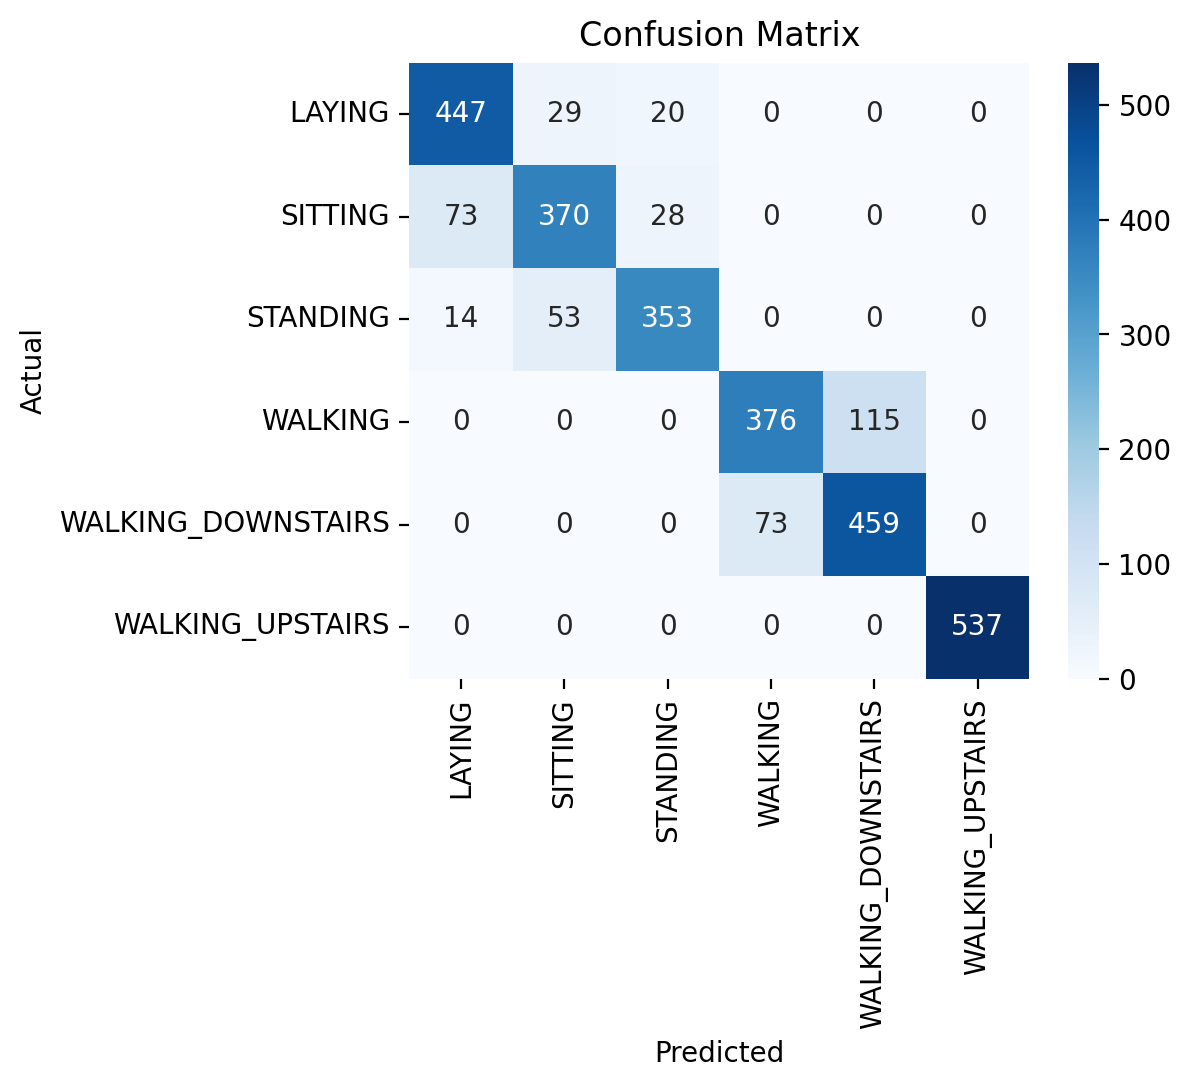

In [43]:
features_tree = DecisionTreeClassifier()
features_tree.fit(X_train_features,y_train_features)
y_pred = features_tree.predict(X_test_features)
print(f"Accuracy = {accuracy_score(y_test_features,y_pred)}")
print(f"Precision = {precision_score(y_test_features,y_pred,average='weighted')}")
print(f"Recall = {recall_score(y_test_features,y_pred,average='weighted')}")
print(f"F1 Score = {f1_score(y_test_features,y_pred,average='weighted')}")
cm = confusion_matrix(y_test_features,y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The accuracies of the three models are:
1. Raw data: 51.85 %
2. TSFEL data: 81.48%
3. Features in the dataset: 86.25 %
<br>
Therefore, the best model with respect to accuracy score is the model trained on features provided by the dataset.

### Task 2, Question 2

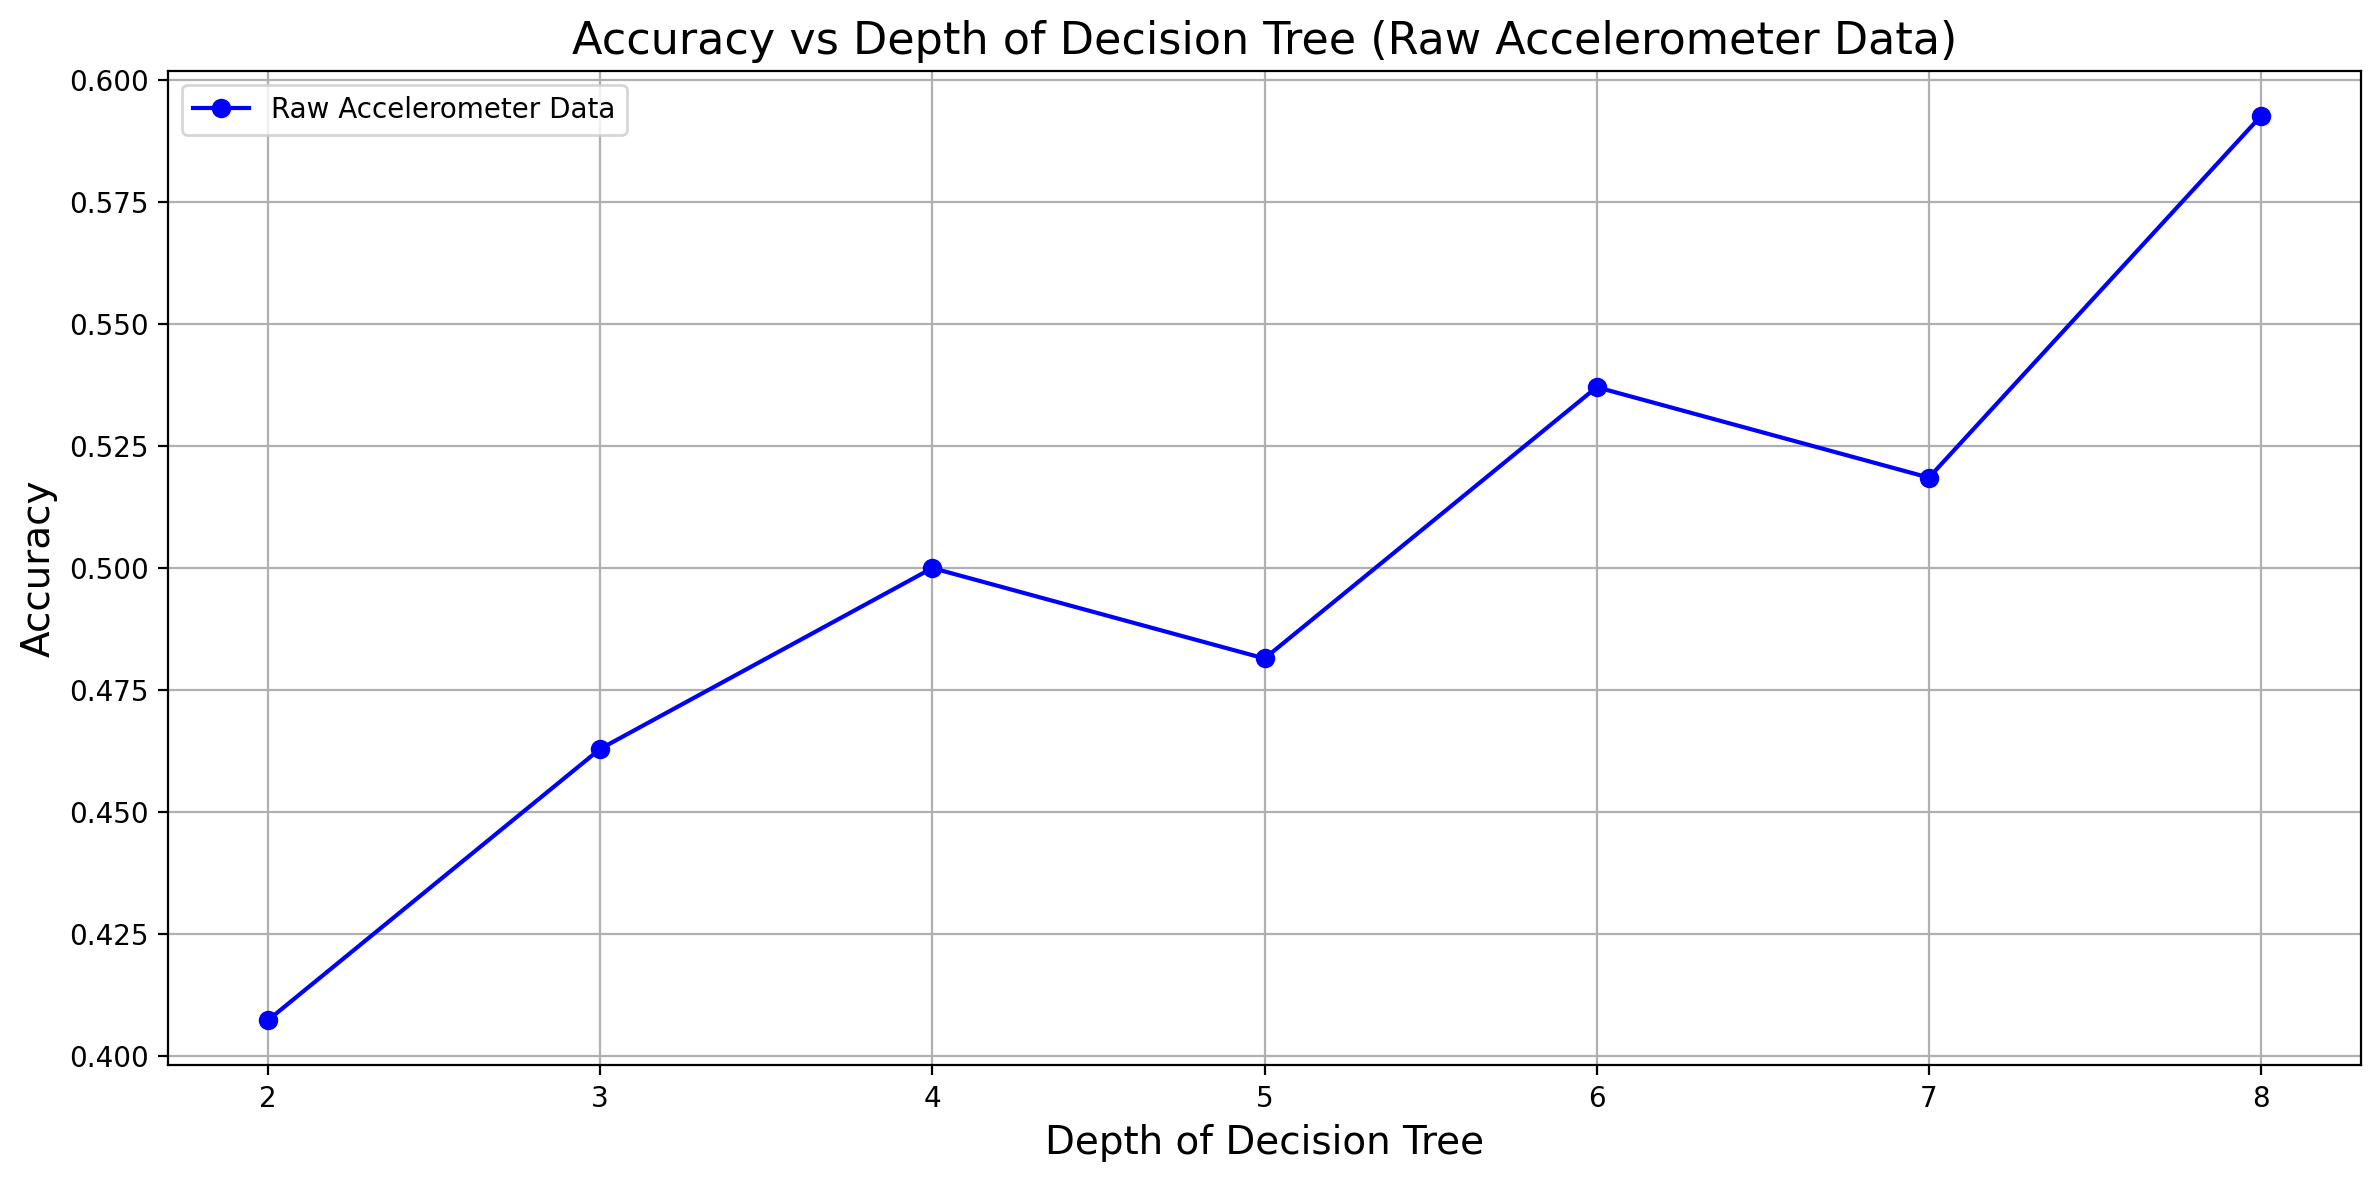

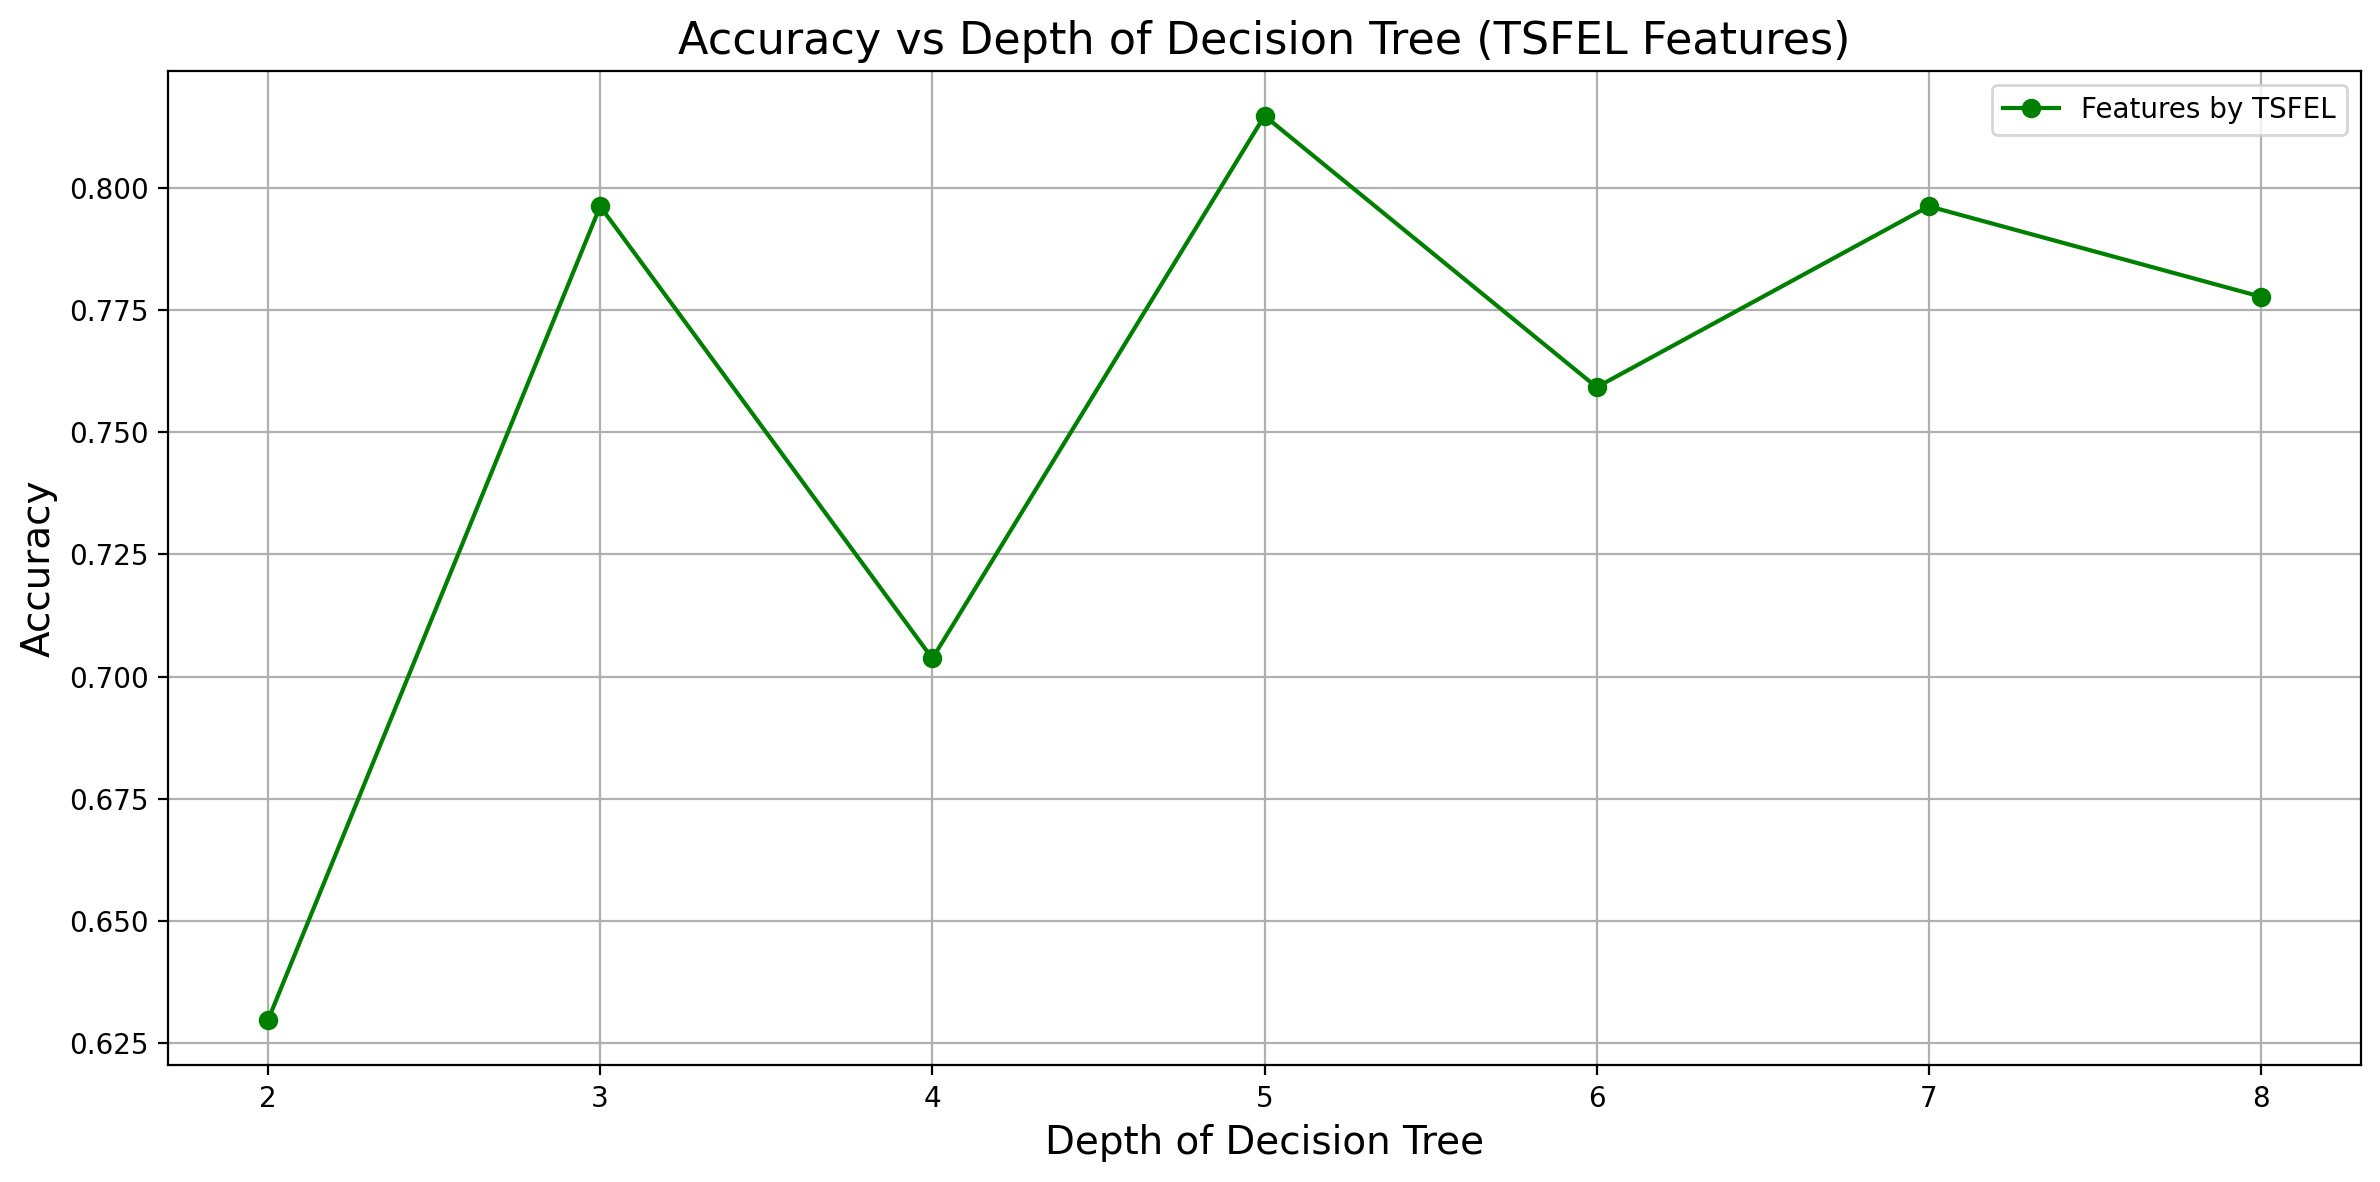

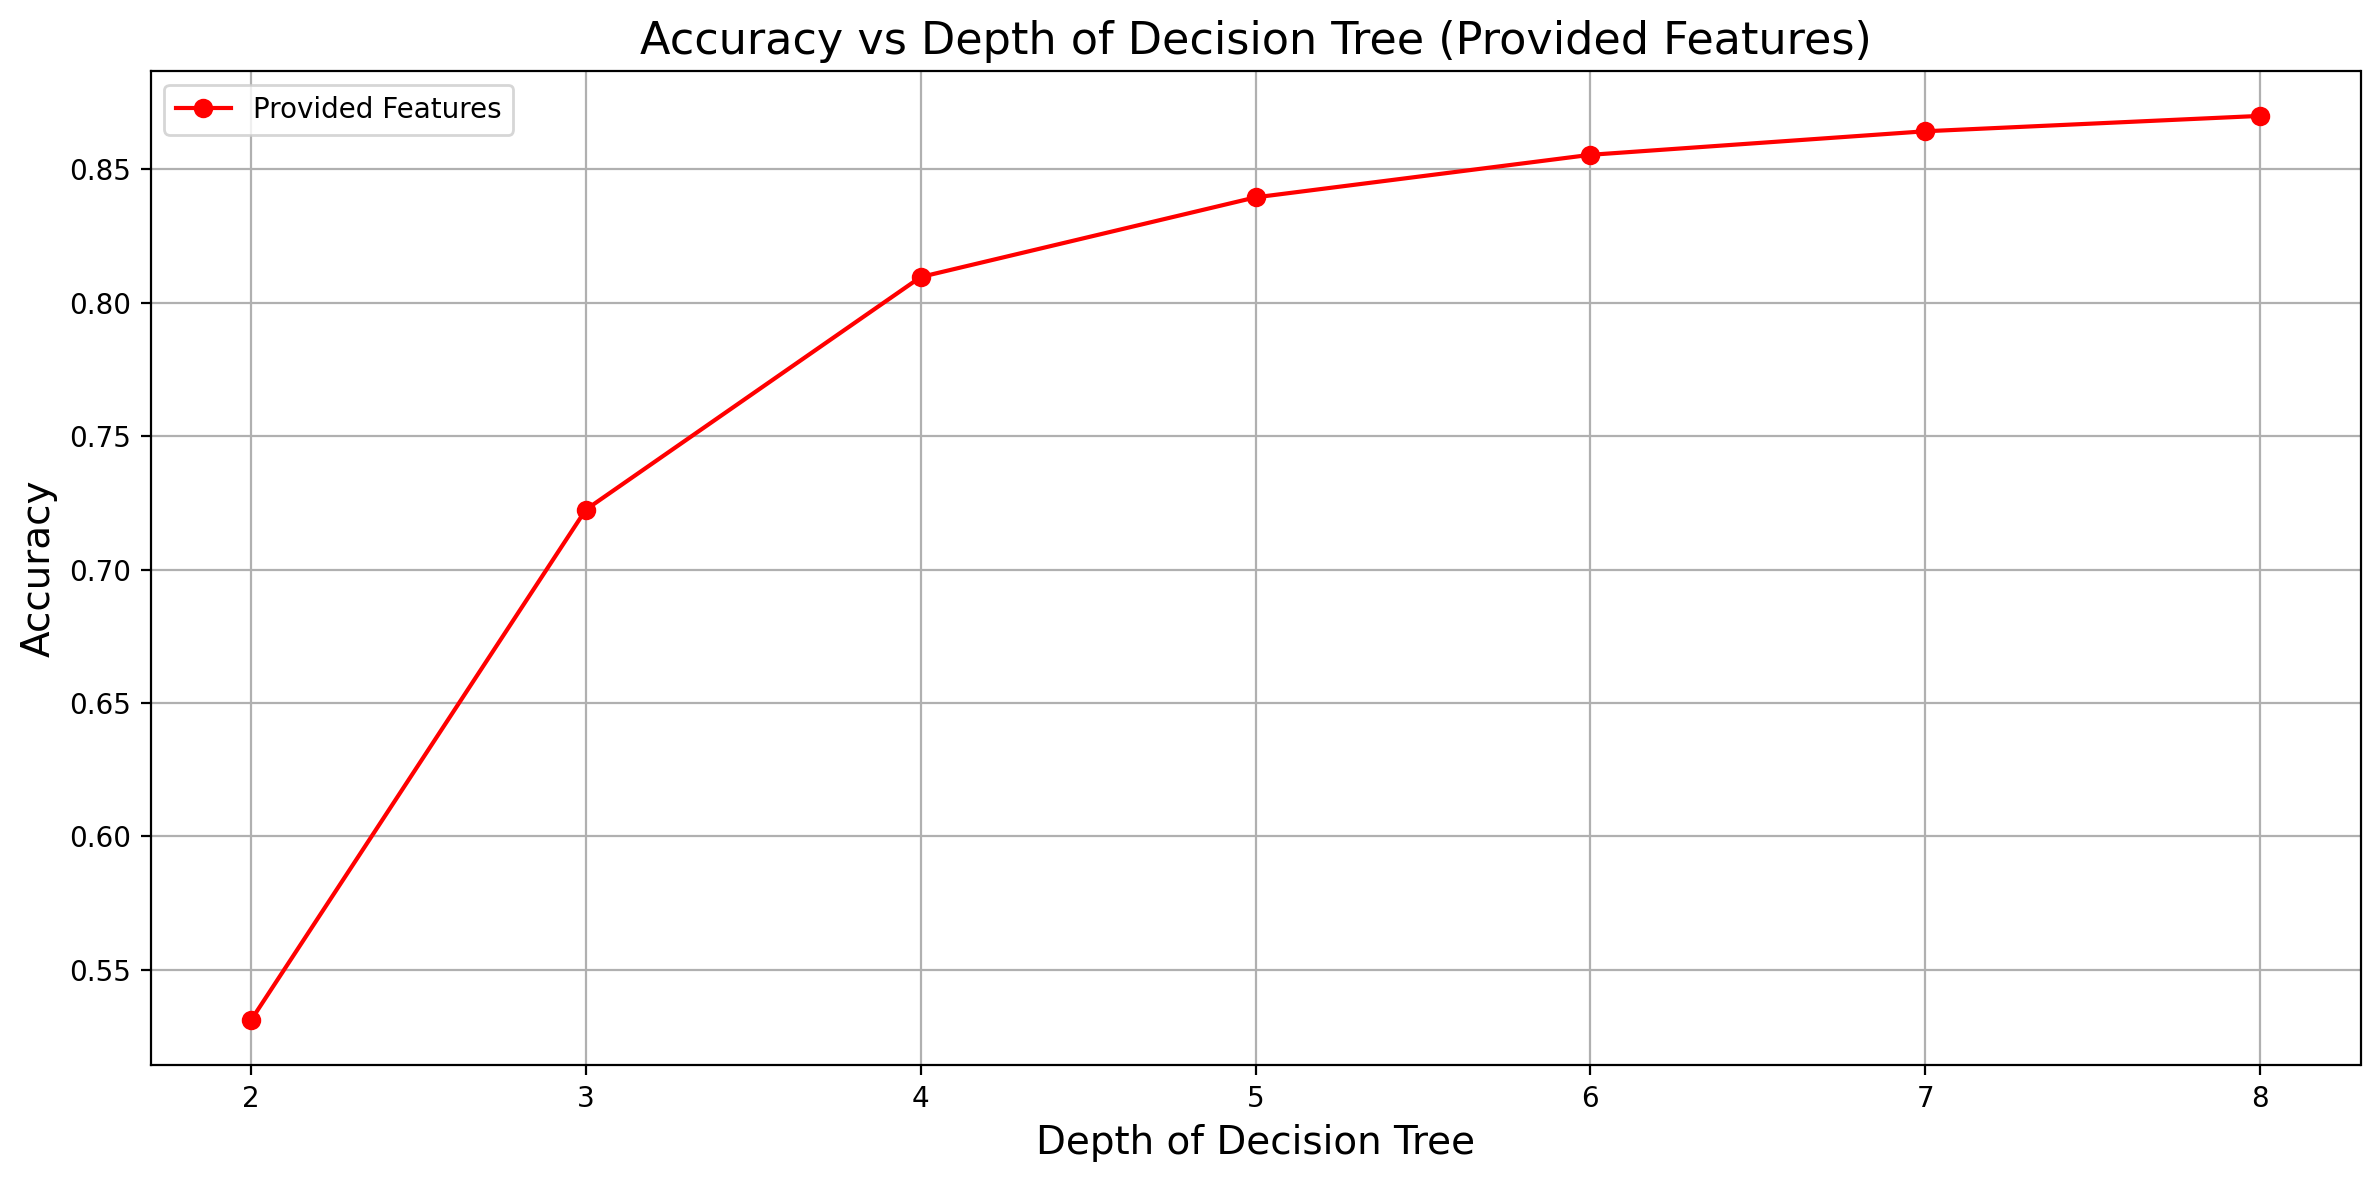

In [44]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = range(2, 9)
accuracies_raw = []
accuracies_tsfel = []
accuracies_features = []


# Train and evaluate Decision Tree with raw accelerometer data
for depth in depths:
    raw_tree = DecisionTreeClassifier(max_depth=depth)
    raw_tree.fit(total_acceleration, y_train)

    y_predict_raw = raw_tree.predict(total_acceleration_x_test)
    accuracies_raw.append(accuracy_score(y_test, y_predict_raw))

# Plot accuracy vs depth for raw accelerometer data
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_raw, marker='o', linestyle='-', color='b', label='Raw Accelerometer Data')
plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree (Raw Accelerometer Data)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train and evaluate Decision Tree with TSFEL features
for depth in depths:
    tsfel_tree = DecisionTreeClassifier(max_depth=depth)
    tsfel_tree.fit(tsfel_features_train, y_train)

    y_predict_tsfel = tsfel_tree.predict(tsfel_features_test)
    accuracies_tsfel.append(accuracy_score(y_test, y_predict_tsfel))

# Plot accuracy vs depth for features obtained by TSFEL
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_tsfel, marker='o', linestyle='-', color='g', label='Features by TSFEL')
plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree (TSFEL Features)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train and evaluate Decision Tree with provided features
for depth in depths:
    features_tree = DecisionTreeClassifier(max_depth=depth)
    features_tree.fit(X_train_features,y_train_features)

    y_predict_features = features_tree.predict(X_test_features)
    accuracies_features.append(accuracy_score(y_test_features, y_predict_features))

# Plot accuracy vs depth for provided features
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_features, marker='o', linestyle='-', color='r', label='Provided Features')
plt.xlabel('Depth of Decision Tree', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs Depth of Decision Tree (Provided Features)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Task 2, Question 3